In [ ]:
"""
Project 2: Stock Trade Gap Analysis using Graph Database

Objectives
        Develop a Stock Trade Gap Analysis System – Build a system to analyze stock trade data and identify gaps or inconsistencies.
        
        Construct a Graph-Based Trade Model – Store stock trade data in a Neo4j graph database, representing trades as nodes and relationships between them as edges.
        
        Identify Gaps in Trading Patterns – Implement a gap analysis algorithm to detect missing trades, unusual price jumps, and inconsistencies.
        
        Compare Actual Trades with Expected Patterns – Define trade benchmarks and identify deviations from expected behavior.
        
        Visualize and Report Insights – Generate interactive visualizations and summary reports highlighting trade gaps and anomalies.
        
"""

In [17]:
!pip install neo4j pandas numpy scipy networkx matplotlib


In [18]:
##Connect to Neo4j##
from neo4j import GraphDatabase

# Neo4j connection details
URL = "bolt://localhost:7687"  
USERNAME = "neo4j"
PASSWORD = "password"

# Connect to Neo4j
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

print("Connected to Neo4j successfully!")

Connected to Neo4j successfully!


In [19]:

import pandas as pd
import numpy as np

# Generate sample stock trade data with gaps
np.random.seed(42)

data = {
    "trade_id": range(1, 21),  
    "ticker": ["AAPL"] * 10 + ["MSFT"] * 10, 
    "volume": [1000, 1200, 0, 1100, 1300,  
               1400, 1250, 0, 1150, 1350,  
               2000, 0, 2100, 2500, 2600,  
               2700, 2550, 2300, 0, 2450],  
    "price": [150, 152, 180, 151, 153,  
              154, 149, 0, 150, 155,  
              300, 0, 305, 310, 315,  
              318, 312, 290, 0, 295],  
    "timestamp": pd.date_range("2024-02-01", periods=20, freq="h")  
}

# Convert to DataFrame
df = pd.DataFrame(data)

print(df)


    trade_id ticker  volume  price           timestamp
0          1   AAPL    1000    150 2024-02-01 00:00:00
1          2   AAPL    1200    152 2024-02-01 01:00:00
2          3   AAPL       0    180 2024-02-01 02:00:00
3          4   AAPL    1100    151 2024-02-01 03:00:00
4          5   AAPL    1300    153 2024-02-01 04:00:00
5          6   AAPL    1400    154 2024-02-01 05:00:00
6          7   AAPL    1250    149 2024-02-01 06:00:00
7          8   AAPL       0      0 2024-02-01 07:00:00
8          9   AAPL    1150    150 2024-02-01 08:00:00
9         10   AAPL    1350    155 2024-02-01 09:00:00
10        11   MSFT    2000    300 2024-02-01 10:00:00
11        12   MSFT       0      0 2024-02-01 11:00:00
12        13   MSFT    2100    305 2024-02-01 12:00:00
13        14   MSFT    2500    310 2024-02-01 13:00:00
14        15   MSFT    2600    315 2024-02-01 14:00:00
15        16   MSFT    2700    318 2024-02-01 15:00:00
16        17   MSFT    2550    312 2024-02-01 16:00:00
17        

In [20]:
def insert_trade(tx, trade):
    query = """
    CREATE (t:Trade {trade_id: $trade_id, ticker: $ticker, 
                     volume: $volume, price: $price, timestamp: $timestamp})
    """
    tx.run(query, **trade)

# Insert each row from DataFrame into Neo4j
with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insert_trade, row.to_dict())

print("Inserted stock trades into Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_18124\1622865743.py:11: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_trade, row.to_dict())


Inserted stock trades into Neo4j!


In [21]:
def create_relationships(tx):
    query = """
    MATCH (t1:Trade), (t2:Trade) 
    WHERE t1.timestamp < t2.timestamp
    CREATE (t1)-[:NEXT_TRADE]->(t2)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_relationships)

print("Created relationships between consecutive trades!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_18124\3646119446.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_relationships)


Created relationships between consecutive trades!


In [22]:
df["missing_volume"] = df["volume"] == 0
df["missing_price"] = df["price"] == 0

# Compute price change between consecutive trades
df["price_change"] = df["price"].diff().fillna(0).abs()
df["sudden_jump"] = df["price_change"] > 20  # Define threshold for jumps

# Define gaps
df["is_gap"] = df["missing_volume"] | df["missing_price"] | df["sudden_jump"]

print(df[["trade_id", "missing_volume", "missing_price", "sudden_jump", "is_gap"]])


    trade_id  missing_volume  missing_price  sudden_jump  is_gap
0          1           False          False        False   False
1          2           False          False        False   False
2          3            True          False         True    True
3          4           False          False         True    True
4          5           False          False        False   False
5          6           False          False        False   False
6          7           False          False        False   False
7          8            True           True         True    True
8          9           False          False         True    True
9         10           False          False        False   False
10        11           False          False         True    True
11        12            True           True         True    True
12        13           False          False         True    True
13        14           False          False        False   False
14        15           Fa

In [23]:
def mark_gaps(tx, trade_id, is_gap):
    query = """
    MATCH (t:Trade {trade_id: $trade_id})
    SET t.is_gap = $is_gap
    """
    tx.run(query, trade_id=int(trade_id), is_gap=bool(is_gap))

with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(mark_gaps, row["trade_id"], row["is_gap"])

print("Marked gaps in Neo4j!")


C:\Users\loksa\AppData\Local\Temp\ipykernel_18124\4010075300.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(mark_gaps, row["trade_id"], row["is_gap"])


Marked gaps in Neo4j!


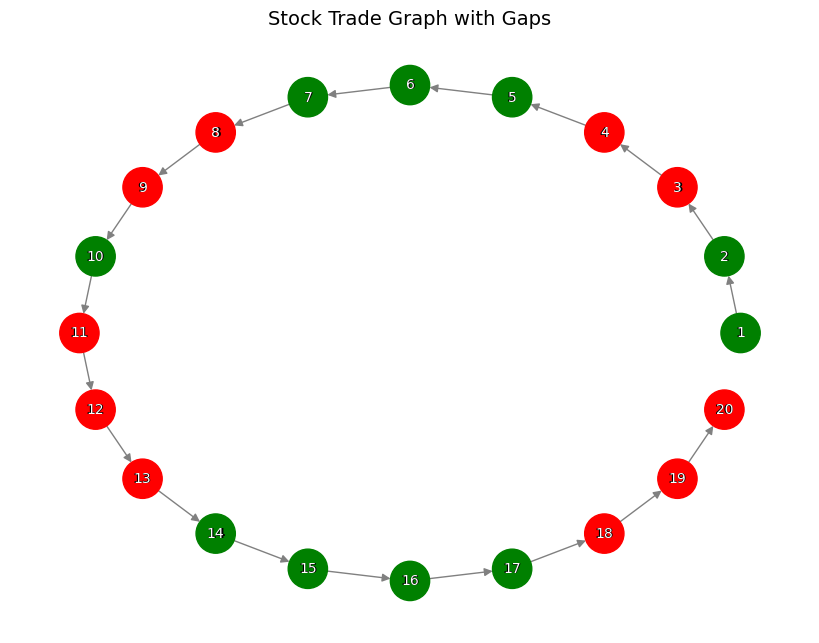

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()

# Add nodes (trades)
for _, row in df.iterrows():
    color = "red" if row.get("is_gap", False) else "green"  # Ensure column exists
    G.add_node(row["trade_id"], color=color, label=f"{row['trade_id']}")

# Add edges (NEXT_TRADE relationships)
for i in range(len(df) - 1):
    G.add_edge(df.loc[i, "trade_id"], df.loc[i+1, "trade_id"])

# Define layout
pos = nx.circular_layout(G)  # Use circular layout for better clarity

# Get colors
node_colors = [G.nodes[n]["color"] for n in G.nodes]

# Draw graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=800, font_size=10, font_weight="bold", arrowsize=12)

# Draw node labels
labels = {n: G.nodes[n]["label"] for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="white")

plt.title("Stock Trade Graph with Gaps", fontsize=14)
plt.show()


In [1]:
!pip install gradio 

In [2]:
import gradio as gr
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from neo4j import GraphDatabase

# Connect to Neo4j
URL = "bolt://localhost:7687"  
USERNAME = "neo4j"
PASSWORD = "password"

driver = GraphDatabase.driver(URL, auth=(USERNAME, PASSWORD))
print("Connected to Neo4j successfully!")

# Generate sample stock trade data with gaps
np.random.seed(42)
data = {
    "trade_id": range(1, 21),
    "ticker": ["AAPL"] * 10 + ["MSFT"] * 10,
    "volume": [1000, 1200, 0, 1100, 1300, 1400, 1250, 0, 1150, 1350,
               2000, 0, 2100, 2500, 2600, 2700, 2550, 2300, 0, 2450],
    "price": [150, 152, 180, 151, 153, 154, 149, 0, 150, 155,
              300, 0, 305, 310, 315, 318, 312, 290, 0, 295],
    "timestamp": pd.date_range("2024-02-01", periods=20, freq="h")
}

df = pd.DataFrame(data)

# Insert trades into Neo4j
def insert_trade(tx, trade):
    query = """
    CREATE (t:Trade {trade_id: $trade_id, ticker: $ticker, 
                     volume: $volume, price: $price, timestamp: $timestamp})
    """
    tx.run(query, **trade)

with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insert_trade, row.to_dict())

print("Inserted stock trades into Neo4j!")

# Create relationships between trades
def create_relationships(tx):
    query = """
    MATCH (t1:Trade), (t2:Trade) 
    WHERE t1.timestamp < t2.timestamp
    CREATE (t1)-[:NEXT_TRADE]->(t2)
    """
    tx.run(query)

with driver.session() as session:
    session.write_transaction(create_relationships)

print("Created relationships between consecutive trades!")

# Identify gaps
df["missing_volume"] = df["volume"] == 0
df["missing_price"] = df["price"] == 0
df["price_change"] = df["price"].diff().fillna(0).abs()
df["sudden_jump"] = df["price_change"] > 20
df["is_gap"] = df["missing_volume"] | df["missing_price"] | df["sudden_jump"]

# Mark gaps in Neo4j
def mark_gaps(tx, trade_id, is_gap):
    query = """
    MATCH (t:Trade {trade_id: $trade_id})
    SET t.is_gap = $is_gap
    """
    tx.run(query, trade_id=int(trade_id), is_gap=bool(is_gap))

with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(mark_gaps, row["trade_id"], row["is_gap"])

print("Marked gaps in Neo4j!")

# Function to visualize trade graph
def plot_graph():
    G = nx.DiGraph()

    # Add nodes (trades)
    for _, row in df.iterrows():
        color = "red" if row["is_gap"] else "green"
        G.add_node(row["trade_id"], color=color, label=f"{row['trade_id']}")

    # Add edges (NEXT_TRADE relationships)
    for i in range(len(df) - 1):
        G.add_edge(df.loc[i, "trade_id"], df.loc[i+1, "trade_id"])

    # Define layout
    pos = nx.spring_layout(G, seed=42)  # Clear and structured layout
    node_colors = [G.nodes[n]["color"] for n in G.nodes]

    # Draw graph
    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray",
            node_size=800, font_size=10, font_weight="bold", arrowsize=12, ax=ax)

    # Draw node labels
    labels = {n: G.nodes[n]["label"] for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="white", ax=ax)

    plt.title("Stock Trade Graph with Gaps", fontsize=14)
    return fig

# Function to display data table
def show_data():
    return df

# Gradio UI
gui = gr.Interface(
    fn=plot_graph,
    inputs=[],
    outputs=gr.Plot(),
    live=False,
    title="Stock Trade Graph with Gaps"
)

data_table = gr.Interface(
    fn=show_data,
    inputs=[],
    outputs=gr.Dataframe(),
    title="Trade Data Table"
)

demo = gr.TabbedInterface([gui, data_table], ["Graph", "Data Table"])
demo.launch()


Connected to Neo4j successfully!


C:\Users\loksa\AppData\Local\Temp\ipykernel_2344\3061114045.py:40: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_trade, row.to_dict())


Inserted stock trades into Neo4j!


C:\Users\loksa\AppData\Local\Temp\ipykernel_2344\3061114045.py:54: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_relationships)


Created relationships between consecutive trades!


C:\Users\loksa\AppData\Local\Temp\ipykernel_2344\3061114045.py:75: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(mark_gaps, row["trade_id"], row["is_gap"])


Marked gaps in Neo4j!
* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
